# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [2]:
# Imports & Setups

import pandas as pd
import pandas.tseries

import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [3]:
#!pip install -U fsds_100719
from fsds_100719.imports import *


import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-poster')

fsds_1007219  v0.6.4 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


In [4]:
# Import Data

df=pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-online-ds-ft-100719/master/zillow_data.csv')#'zillow_data.csv')
df.head().style.set_caption("ORIGINAL WIDE FORMAT")

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200,335400,336500,337600,338500,339500,340400,341300,342600,344400,345700,346700,347800,349000,350400,352000,353900,356200,358800,361800,365700,370200,374700,378900,383500,388300,393300,398500,403800,409100,414600,420100,426200,432600,438600,444200,450000,455900,462100,468500,475300,482500,490200,498200,507200,516800,526300,535300,544500,553500,562400,571200,579800,588100,596300,604200,612200,620200,627700,634500,641000,647000,652700,658100,663300,668400,673400,678300,683200,688300,693300,698000,702400,706400,710200,714000,717800,721700,725700,729900,733400,735600,737200,739000,740900,742700,744400,746000,747200,748000,749000,750200,752300,755300,759200,764000,769600,775600,781900,787900,793200,798200,803100,807900,812900,818100,823100,828300,834100,839800,845600,851800,858000,864400,870700,876200,880700,884400,887600,890500,893300,895500,897300,899000,900400,902000,904400,907100,909700,911900,913000,913000,912000,909300,905300,901400,897900,895400,893600,891100,887000,881700,875900,870300,865100,859000,851500,843800,836400,830700,827300,824800,821600,818300,814600,809800,803600,795500,786900,780700,776900,774700,774200,774400,774600,775600,777800,775200,767900,764700,766100,764100,759700,754900,746200,737300,730800,729300,730200,730700,730000,730100,730100,731200,733900,735500,735400,734400,737500,737700,733700,734000,740300,744600,750500,760400,771800,780600,787900,794100,798900,802300,806100,810900,817400,826800,837900,848100,853800,856700,856600,854400,853000,856200,859700,863900,872900,883300,889500,892800,893600,891300,889900,891500,893000,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,9991

In [5]:
fs.quick_refs.ts_pandas_freq_aliases()

PANDAS TIME FREQUENCY ALIASES
[i] Documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases


| Alias | Description |
    |----|-----|
    |B|business day frequency|
    |C|custom business day frequency|
    |D|calendar day frequency|
    |W|weekly frequency|
    |M|month end frequency|
    |SM|semi-month end frequency (15th and end of month)|
    |BM|business month end frequency|
    |CBM|custom business month end frequency|
    |MS|month start frequency|
    |SMS|semi-month start frequency (1st and 15th)|
    |BMS|business month start frequency|
    |CBMS|custom business month start frequency|
    |Q|quarter end frequency|
    |BQ|business quarter end frequency|
    |QS|quarter start frequency|
    |BQS|business quarter start frequency|
    |A, Y| year end frequency|
    |BA, BY |business year end frequency|
    |AS, YS |year start frequency|
    |BAS, BYS |business year start frequency|
    |BH|business hour frequency|
    |H|hourly frequency|
    |T, min |minutely frequency|
    |S|secondly frequency|
    |L, ms|milliseconds|
    |U, us |microseconds|
    |N|nanoseconds|
    

# Step 2: Data Preprocessing

In [6]:
# Melt Data

def melt_data(df):
    
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [7]:
df = melt_data(df)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [8]:
# Set Datetime Index

def make_datetimeindex(df,col_to_make_index = 'Month',drop=False,verbose=True):

    df[col_to_make_index] = pd.to_datetime(df[col_to_make_index],errors='coerce')
    df = df.set_index('Month',drop=drop)
    if verbose:
        display(df.index)
    return df

In [9]:
df = make_datetimeindex(df)

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=3744704, freq=None)

In [10]:
# Groupby Zip Code or the RegionName

df2 = df.drop('Month', axis=1).groupby('City').get_group("Chicago")

df2

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MeanValue
Month,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0
1996-04-01,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0
1996-04-01,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0
...,...,...,...,...,...,...,...,...
2018-04-01,84653,60656,Chicago,IL,Chicago,Cook,3157,304000.0
2018-04-01,84652,60655,Chicago,IL,Chicago,Cook,3961,232600.0
2018-04-01,84645,60646,Chicago,IL,Chicago,Cook,4041,401300.0


In [11]:
df2.index

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=10658, freq=None)

In [12]:
df2.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MeanValue
Month,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0
1996-04-01,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0
1996-04-01,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0


In [13]:
chicago = df2.groupby('RegionName').resample('MS').asfreq()
chicago


RegionID  RegionName     City State    Metro  \
RegionName Month                                                      
60605      1996-04-01     84607       60605  Chicago    IL  Chicago   
           1996-05-01     84607       60605  Chicago    IL  Chicago   
           1996-06-01     84607       60605  Chicago    IL  Chicago   
           1996-07-01     84607       60605  Chicago    IL  Chicago   
           1996-08-01     84607       60605  Chicago    IL  Chicago   
...                         ...         ...      ...   ...      ...   
60660      2017-12-01     84656       60660  Chicago    IL  Chicago   
           2018-01-01     84656       60660  Chicago    IL  Chicago   
           2018-02-01     84656       60660  Chicago    IL  Chicago   
           2018-03-01     84656       60660  Chicago    IL  Chicago   
           2018-04-01     84656       60660  Chicago    IL  Chicago   

                      CountyName  SizeRank  MeanValue  
RegionName Month                                       
60605      1996-04-01       Cook      1361   293500.0  
           1996-05-01       Cook      1361   293000.0  
           1996-06-01       Cook      1361   292500.0  
           1996-07-01       Cook      1361   291700.0  
           1996-08-01       Cook      1361   290900.0  
...                          ...       ...        ...  
60660      2017-12-01       Cook       348   517700.0  
           2018-01-01       Cook       348   521500.0  
           2018-02-01       Cook       348   524100.0  
           2018-03-01       Cook       348   526300.0  
           2018-04-01       Cook       348   526300.0  

[10658 rows x 8 columns]

In [14]:
chicago.reset_index(inplace=True,level=0,drop=True)
chicago.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MeanValue
Month,,,,,,,,
1996-04-01,84607,60605,Chicago,IL,Chicago,Cook,1361,293500.0
1996-05-01,84607,60605,Chicago,IL,Chicago,Cook,1361,293000.0
1996-06-01,84607,60605,Chicago,IL,Chicago,Cook,1361,292500.0
1996-07-01,84607,60605,Chicago,IL,Chicago,Cook,1361,291700.0
1996-08-01,84607,60605,Chicago,IL,Chicago,Cook,1361,290900.0


In [15]:
chicago.index


DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=10658, freq=None)

In [16]:
#b/c resample search for missing values

chicago.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
MeanValue     0
dtype: int64

# Step 3: EDA and Visualization

## Reseach will focus on the far Northside of Chicago

### Far Northside neighboods includes: Rogars Park, Edgewater, Andersonville, Lincoln Square, Ravenswood, Uptown, North Center, Lakeview & Roscoe Village.

In [17]:
far_northside = [60613, 60618, 60625, 60630, 60640, 60645, 60657, 60659, 60660]

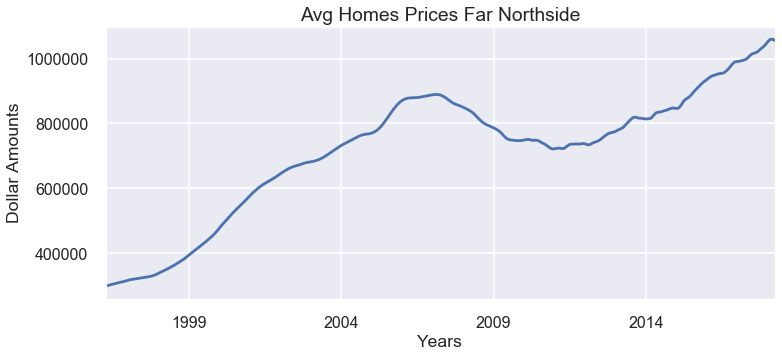

In [18]:
ts = chicago.groupby('RegionName').get_group(far_northside[0]).resample('MS').asfreq()
ts['MeanValue'].plot(figsize=(12,5))
plt.title('Avg Homes Prices Far Northside')
plt.ylabel('Dollar Amounts')
plt.xlabel('Years')
plt.show()

In [19]:
#Function to return zip code(s).  
#Can either enter var name that I've given to group_name or just enter zip code(s)

def get_ts_from_chicago(chicago, group_name):

    ts = chicago.groupby('RegionName').get_group(group_name)
    ts = ts.resample('MS').asfreq()
    ts = ts['MeanValue'].rename(group_name)
    return ts

In [20]:
ts= get_ts_from_chicago(chicago, 60625)

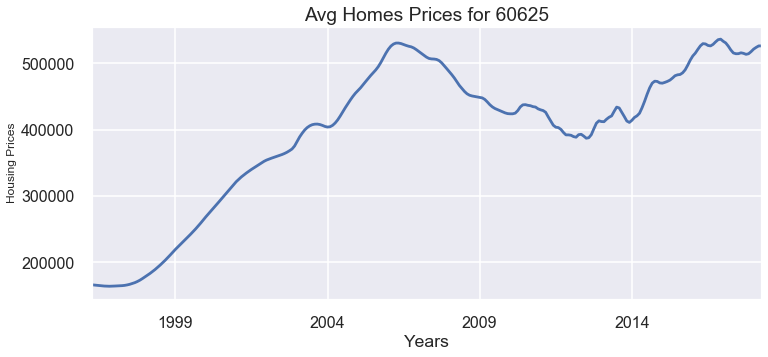

In [67]:
ts.plot()
plt.title('Avg Homes Prices for 60625')
plt.ylabel('Housing Prices', fontsize= 12)
plt.xlabel('Years')
plt.show()

In [22]:
ts.index


DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=265, freq='MS')

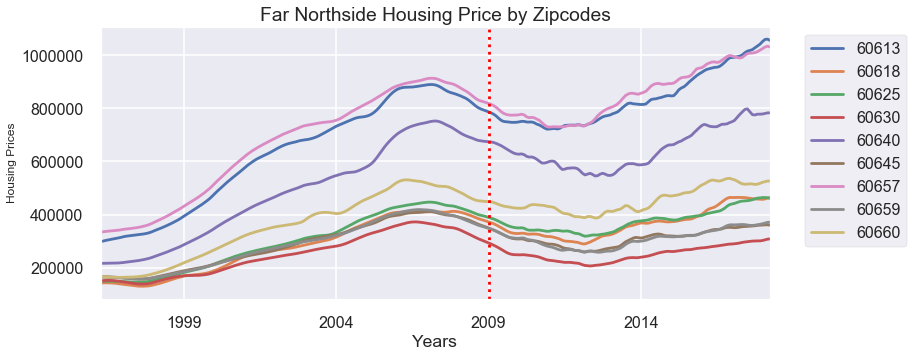

In [68]:
for i in range(len(far_northside)):
    ts = chicago.groupby('RegionName').get_group(far_northside[i])
    ts = ts.resample('MS').asfreq()
    ts['MeanValue'].rename(far_northside[i]).plot(figsize= (12,5))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=1) 
plt.title('Far Northside Housing Price by Zipcodes')
crash = '01-2009'
plt.axvline(crash, label='Housing Index Drops',color='red',ls=':')
plt.ylabel('Housing Prices', fontsize= 12)
plt.xlabel('Years')
plt.show()


### top 5 zipcodes from above:
60657 is Lakeview;
60613 is Lakeview (as well);
60640 is Uptown;
60660 is Edgewater;
60625 is Lincoln Square/Ravenswood;
The rest of the neighborhoods except for Edgebrook (the red line) trends are similar prices

### Graph of home prices for the middle part of the chart

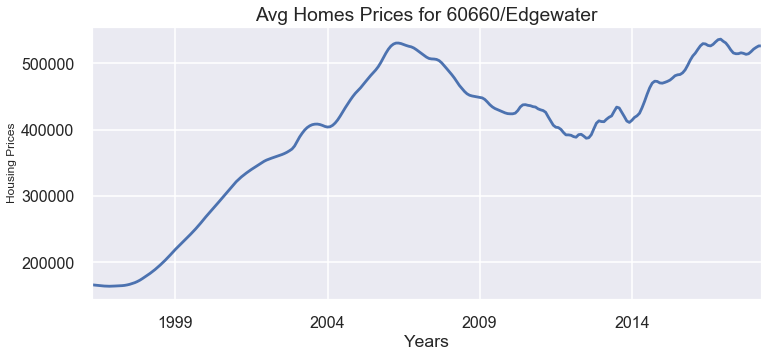

In [69]:
ts_edgewater = get_ts_from_chicago(chicago, 60660)
ts_edgewater.plot()
plt.title('Avg Homes Prices for 60660/Edgewater')
plt.ylabel('Housing Prices', fontsize= 12)
plt.xlabel('Years')
plt.show()

### Edgewater:  160k to 525k

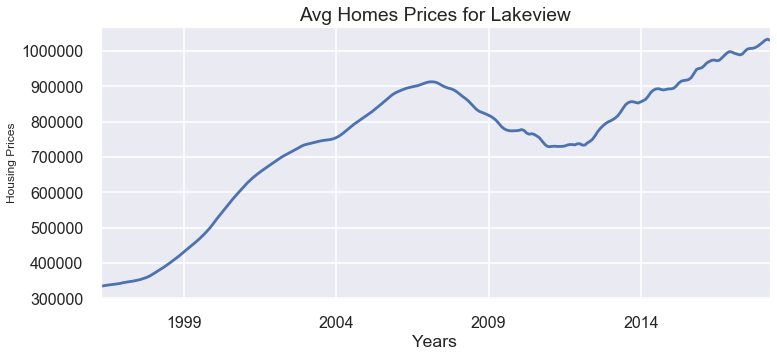

In [70]:
lakeview_ts = get_ts_from_chicago(chicago, 60657)
lakeview_ts.plot()
plt.title('Avg Homes Prices for Lakeview')
plt.ylabel('Housing Prices', fontsize= 12)
plt.xlabel('Years')
plt.show()

## Decomposition

In [26]:
ts

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,MeanValue
Month,,,,,,,,
1996-04-01,84656,60660,Chicago,IL,Chicago,Cook,348,166000.0
1996-05-01,84656,60660,Chicago,IL,Chicago,Cook,348,165600.0
1996-06-01,84656,60660,Chicago,IL,Chicago,Cook,348,165200.0
1996-07-01,84656,60660,Chicago,IL,Chicago,Cook,348,164800.0
1996-08-01,84656,60660,Chicago,IL,Chicago,Cook,348,164400.0
...,...,...,...,...,...,...,...,...
2017-12-01,84656,60660,Chicago,IL,Chicago,Cook,348,517700.0
2018-01-01,84656,60660,Chicago,IL,Chicago,Cook,348,521500.0
2018-02-01,84656,60660,Chicago,IL,Chicago,Cook,348,524100.0


In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
from  statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot,lag_plot

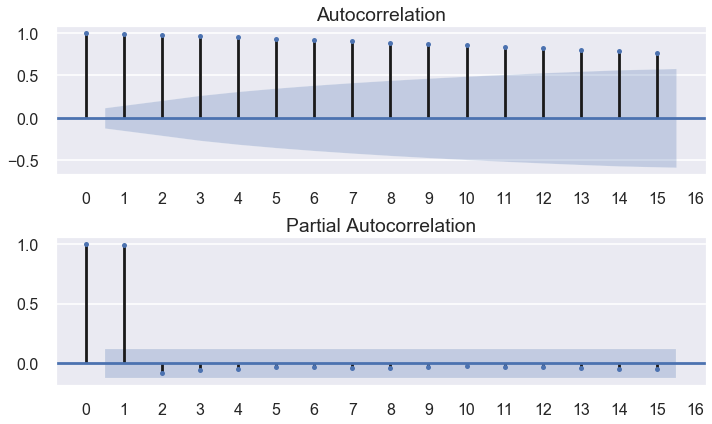

In [28]:
def plot_acf_pacf(ts, figsize=(10,6),lags=15):
    fig,ax = plt.subplots(nrows=2,figsize=figsize)
    plot_acf(ts,ax=ax[0],lags=lags)
    plot_pacf(ts, ax=ax[1],lags=lags) 
    plt.tight_layout()
    
    for a in ax:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    
plot_acf_pacf(ts['MeanValue'])

- AR(p):
    - ACF for AR(p) would be strong until lag of p, then stagnant, then trail off. 
    - PACF for AR(p): Generally no correlation for lag values beyond p.
- MA(q):
    - ACF for MA(q) would show strong correlation up to a lag of q, the immedately delcine to minimal/no correction.
    - PACF would show strong relationship to the lag and tailing off to no correlation afterwards.
   
- Notation is generally ARMA(p,q)
- Example: ARMA(2,1) model equation
     $$Y_t = \mu + \phi_1 Y_{t-1}+\phi_2 Y_{t-2}+ \theta \epsilon_{t-1}+\epsilon_t$$

| Param| AR(p)   |   MA(q)  | ARMA(p,q)|
|------|------|------|------|
|   ACF | Tails off   |  Cuts off after lag q |  Tails off   |
|   PACF | Cuts off after lag p  |   Tails off  |  Tails off  |

### Conclusions for AR(p) and MA(q)

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [30]:
decomp = seasonal_decompose(ts['MeanValue'])

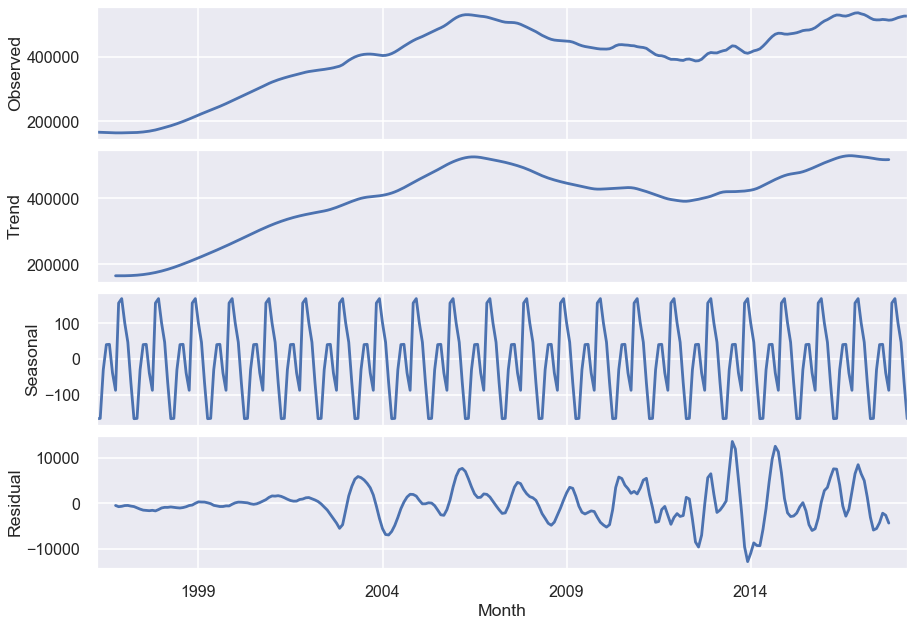

In [31]:
decomp.plot();

#### Conclusion:  The data is non-seasonal because seasonal value is so small in the above chart (compared to size of observed values)

In [32]:
data_diff = ts['MeanValue'].diff().dropna()
data_diff

Month
1996-05-01    -400.0
1996-06-01    -400.0
1996-07-01    -400.0
1996-08-01    -400.0
1996-09-01    -300.0
               ...  
2017-12-01    3200.0
2018-01-01    3800.0
2018-02-01    2600.0
2018-03-01    2200.0
2018-04-01       0.0
Freq: MS, Name: MeanValue, Length: 264, dtype: float64

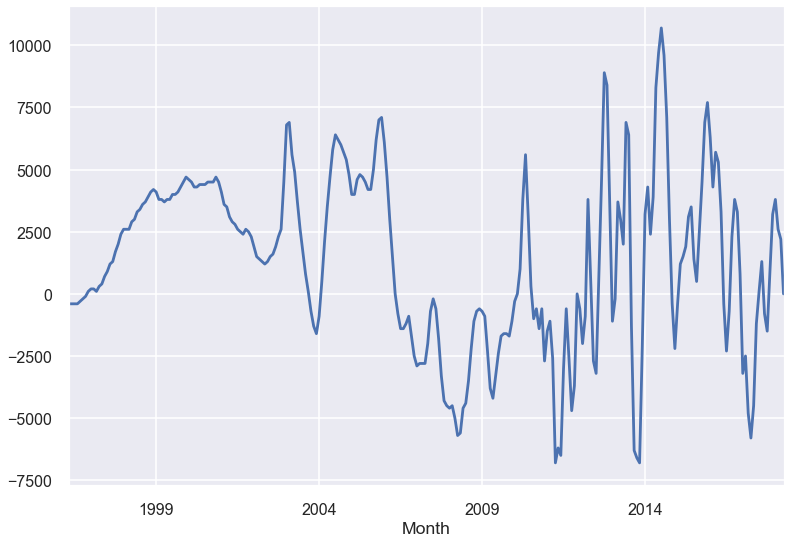

In [33]:
data_diff.plot()

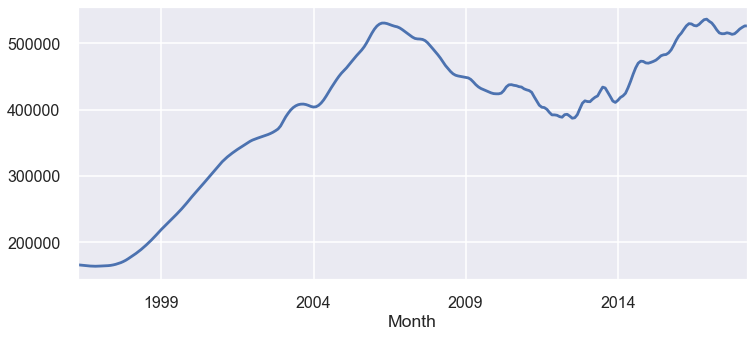

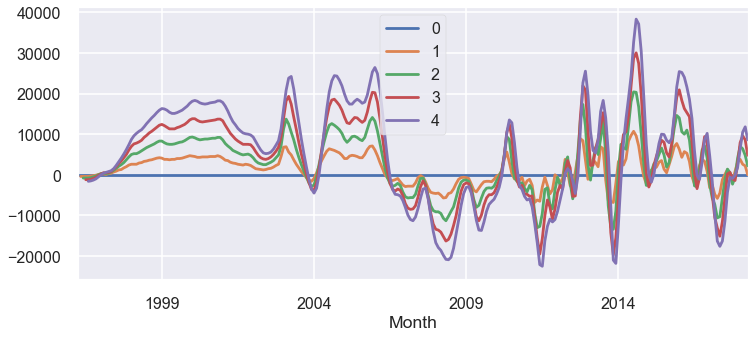

In [34]:
import matplotlib as mpl

mpl.rcParams['figure.figsize']=(12,5)
ts['MeanValue'].plot( )
plt.figure()
for i in range(5):
    ax = ts['MeanValue'].diff(i).plot(label=i)
#     ax.set
ax.legend()

# Step 5: ARIMA Modeling

## Train Test Split 

In [35]:
# fs.ihelp(ji.get_train_test_split_index,0)
def get_train_test_split_index(ts, TEST_SIZE=0.1,min_test_ts=2):
    import math
    idx_split = math.floor(len(ts.index)*(1-TEST_SIZE))
    
    num_test_ts=len(ts.iloc[idx_split:])
    if num_test_ts<min_test_ts:
        print(f'[!] Warning: using TEST_SIZE={TEST_SIZE} produced {num_test_ts} test timestamps.')
        print("- Overriding TEST_SIZE and using min_test_ts instead.")
        idx_split = len(ts)-min_test_ts
    
    return idx_split


def train_test_split_ts(ts,test_size=0.2,min_test_ts=2):
    idx_split = get_train_test_split_index(ts,TEST_SIZE=test_size,
                                           min_test_ts=min_test_ts)
    ts_train = ts.iloc[:idx_split]
    ts_test = ts.iloc[idx_split:]
    return ts_train, ts_test

In [36]:
ts_train, ts_test = train_test_split_ts(ts['MeanValue'], test_size=0.2, min_test_ts=2)  


In [37]:
ts_train.shape ,  ts_test.shape

((212,), (53,))

## Grid Search for Best pdq Parameters

In [38]:
# Creating what to iterate through the models

import itertools

p_range = range(0,4)
q_range = range(0,4)
d_range=range(0,3)


pdq = list(itertools.product(p_range,d_range,q_range))
#PDQM = list(itertools.product(p_range,d_range,q_range,m_range))
pdq[:10]

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 2, 0),
 (0, 2, 1)]

### Reduce size of Train & Test Data for 24 months

In [39]:
ts= get_ts_from_chicago(chicago, 60625)

ts

Month
1996-04-01    148900.0
1996-05-01    149300.0
1996-06-01    149600.0
1996-07-01    149700.0
1996-08-01    149700.0
                ...   
2017-12-01    463100.0
2018-01-01    464100.0
2018-02-01    464200.0
2018-03-01    463200.0
2018-04-01    461100.0
Freq: MS, Name: 60625, Length: 265, dtype: float64

In [40]:
ts_train, ts_test = train_test_split_ts(ts, test_size=0.05, min_test_ts=24) 

[!] Warning: using TEST_SIZE=0.05 produced 14 test timestamps.
- Overriding TEST_SIZE and using min_test_ts instead.


In [41]:
#confirming 24 months 

ts_test.shape


(24,)

## Grid Search for Best Parameters

In [42]:
ts

Month
1996-04-01    148900.0
1996-05-01    149300.0
1996-06-01    149600.0
1996-07-01    149700.0
1996-08-01    149700.0
                ...   
2017-12-01    463100.0
2018-01-01    464100.0
2018-02-01    464200.0
2018-03-01    463200.0
2018-04-01    461100.0
Freq: MS, Name: 60625, Length: 265, dtype: float64

###  Calculate grid with pdq & non-seasonal parameters to obtain best AIC value

In [43]:
ans = [['pdq', 'AIC']]

for comb in pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(ts_train,
                                        order=comb,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
    except:
        continue

### Function to get the best pdq parameters for 1 zip code

In [44]:
# Function to get the best pdq parameters for 1 zip code

def get_best_params(ans):
     
    df_result = pd.DataFrame(ans[1:], columns=ans[0])
    df_result = df_result.sort_values('AIC', ascending= True).reset_index()
    best_params = df_result.iloc[0]['pdq']
    display(df_result.head())
    
    return best_params



In [45]:
get_best_params(ans)

,index,pdq,AIC
0,47,"(3, 2, 3)",3716.484191
1,35,"(2, 2, 3)",3718.042317
2,43,"(3, 1, 3)",3729.027552
3,23,"(1, 2, 3)",3734.526657
4,11,"(0, 2, 3)",3735.819428


(3, 2, 3)

## Modeling with best Parameters (based upon AIC)

### Model Summary

In [46]:

model = sm.tsa.statespace.SARIMAX(ts_train,
                                        order=get_best_params(ans),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

output = model.fit()

output.summary()

,index,pdq,AIC
0,47,"(3, 2, 3)",3716.484191
1,35,"(2, 2, 3)",3718.042317
2,43,"(3, 1, 3)",3729.027552
3,23,"(1, 2, 3)",3734.526657
4,11,"(0, 2, 3)",3735.819428


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60625   No. Observations:                  241
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -1851.242
Date:                Fri, 17 Jan 2020   AIC                           3716.484
Time:                        19:05:42   BIC                           3740.701
Sample:                    04-01-1996   HQIC                          3726.247
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0825      0.133     -0.622      0.534      -0.342       0.177
ar.L2          0.2423      0.128      1.892      0.059      -0.009       0.493
ar.L3          0.2090      0.057      3.648      0.000       0.097       0.321
ma.L1          0.7817      0.111      7.022      0.000       0.564       1.000
ma.L2         -0.5142      0.181     -2.834      0.005      -0.870      -0.159
ma.L3         -0.7491      0.100     -7.459      0.000      -0.946      -0.552
sigma2      4.556e+05   3.48e+04     13.082      0.000    3.87e+05    5.24e+05
===================================================================================
Ljung-Box (Q):                       37.21   Jarque-Bera (JB):               144.70
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):              17.14   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
def expected_roi(investment, final_value):
    """This function takes in a series of forecasts to predict the return
    on investment spanning the entire forecast."""
    roi = np.round(((final_value - investment) / investment)*100,3)
    return roi

In [48]:

start=ts_test.index[0]
end=ts_test.index[-1]    
# Get predictions starting from 2016 and calculate confidence intervals.
predictions = output.get_prediction(start=start,end=end, 
                                         dynamic=True)
ts_pred = predictions.predicted_mean

### Model Result

### Graph of Training & Test Data & Prediction

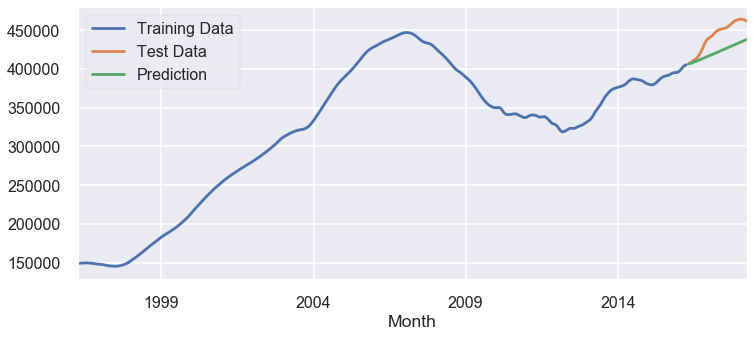

In [49]:
ts_train.plot(label= 'Training Data')
ts_test.plot(label= 'Test Data')
ts_pred.plot(label= 'Prediction')
plt.legend()

### Build Loop for Multi-zip code

#### There are 3 steps/functions for the loop (function name)
1) get params ()
2) create model & fit model ()
3) graph it ()


In [50]:
#Funtion for For Loop for mult zipcodes

def model_multi_zip(ts, params):
    
    model = sm.tsa.statespace.SARIMAX(ts,
                                      order=params,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    output = model.fit()
    display(output.summary())
    return output
    

In [51]:
# Funtion for graphing: Train, Test, Prediction data & confidence interval

def graph_sarimax(ts_train, ts_test, output=output):
    
    start=ts_test.index[0]
    end=ts_test.index[-1]    
    # Getting predictions starting from 2016 and calculate confidence intervals.
    predictions = output.get_prediction(start=start, end= end, dynamic=True)
    ts_pred = predictions.predicted_mean
    ts_conf = predictions.conf_int()  #makes confidence intereval graph
    
    ts_train.plot(label= 'Training Data')
    ts_test.plot(label= 'Test Data')
    ts_pred.plot(label= 'Prediction')
    plt.fill_between(ts_conf.index, ts_conf.iloc[:,0], ts_conf.iloc[:,1])  #confidence interval
    plt.legend()
    plt.ylabel('Dollar Amounts')
    plt.xlabel('Years')
    plt.title('Time Values')
    plt.show()
    
    return ts_pred
    

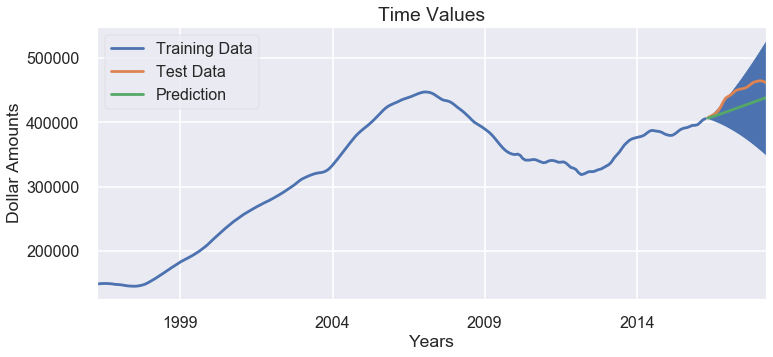

2016-05-01    406391.178362
2016-06-01    407406.125223
2016-07-01    408835.394919
2016-08-01    410049.590990
2016-09-01    411407.777038
2016-10-01    412788.589501
2016-11-01    414157.461018
2016-12-01    415562.898484
2017-01-01    416967.156563
2017-02-01    418377.874529
2017-03-01    419795.417565
2017-04-01    421213.716089
2017-05-01    422634.956142
2017-06-01    424057.563279
2017-07-01    425480.928207
2017-08-01    426905.176715
2017-09-01    428329.821698
2017-10-01    429754.806445
2017-11-01    431180.043919
2017-12-01    432605.425738
2018-01-01    434030.927901
2018-02-01    435456.507937
2018-03-01    436882.140878
2018-04-01    438307.813477
Freq: MS, dtype: float64

In [52]:
graph_sarimax(ts_train, ts_test)

Function to get best parameters for loop for all zip codes

In [53]:
def get_best_params_2(ts, p_range=5, d_range=3, q_range=5, start_date='2016-04-01'):

    ts_train = ts.loc[:start_date]
    ts_test = ts.loc[start_date:]

    import itertools

    p_range = range(0,p_range)
    d_range=range(0,d_range)
    q_range = range(0,q_range)


    pdq = list(itertools.product(p_range,d_range,q_range))
   

    # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = [['pdq', 'AIC']]

    for comb in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_train,
                                            order=comb,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
        
              
    df_result = pd.DataFrame(ans[1:], columns=ans[0])
    df_result = df_result.sort_values('AIC', ascending= True).reset_index()
    best_params = df_result.iloc[0]['pdq']
    display(df_result.head())
    
    return best_params, ts_train, ts_test



In [54]:
ts.head()


Month
1996-04-01    148900.0
1996-05-01    149300.0
1996-06-01    149600.0
1996-07-01    149700.0
1996-08-01    149700.0
Freq: MS, Name: 60625, dtype: float64

In [55]:
params_test, ts_train, ts_test = get_best_params_2(ts, 2,2,2)

,index,pdq,AIC
0,7,"(1, 1, 1)",3839.735514
1,6,"(1, 1, 0)",3892.938477
2,5,"(1, 0, 1)",4228.129228
3,3,"(0, 1, 1)",4235.094626
4,4,"(1, 0, 0)",4440.564494


In [56]:
params_test

(1, 1, 1)

In [57]:
ts_train

Month
1996-04-01    148900.0
1996-05-01    149300.0
1996-06-01    149600.0
1996-07-01    149700.0
1996-08-01    149700.0
                ...   
2015-12-01    395200.0
2016-01-01    396300.0
2016-02-01    399800.0
2016-03-01    403600.0
2016-04-01    405500.0
Freq: MS, Name: 60625, Length: 241, dtype: float64

In [58]:
ts_test                         

Month
2016-04-01    405500.0
2016-05-01    407000.0
2016-06-01    409100.0
2016-07-01    411300.0
2016-08-01    413500.0
2016-09-01    417600.0
2016-10-01    423500.0
2016-11-01    431200.0
2016-12-01    437400.0
2017-01-01    440100.0
2017-02-01    442300.0
2017-03-01    445800.0
2017-04-01    449000.0
2017-05-01    450700.0
2017-06-01    451500.0
2017-07-01    452300.0
2017-08-01    453600.0
2017-09-01    456000.0
2017-10-01    459100.0
2017-11-01    461900.0
2017-12-01    463100.0
2018-01-01    464100.0
2018-02-01    464200.0
2018-03-01    463200.0
2018-04-01    461100.0
Freq: MS, Name: 60625, dtype: float64

In [59]:
output_test = model_multi_zip(ts_train, params_test)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60625   No. Observations:                  241
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1916.868
Date:                Fri, 17 Jan 2020   AIC                           3839.736
Time:                        19:05:44   BIC                           3850.152
Sample:                    04-01-1996   HQIC                          3843.934
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9215      0.026     35.115      0.000       0.870       0.973
ma.L1          0.3780      0.019     20.278      0.000       0.341       0.415
sigma2      5.388e+05   3.49e+04     15.429      0.000     4.7e+05    6.07e+05
===================================================================================
Ljung-Box (Q):                       84.81   Jarque-Bera (JB):                96.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.95   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
type(output_test)

statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper

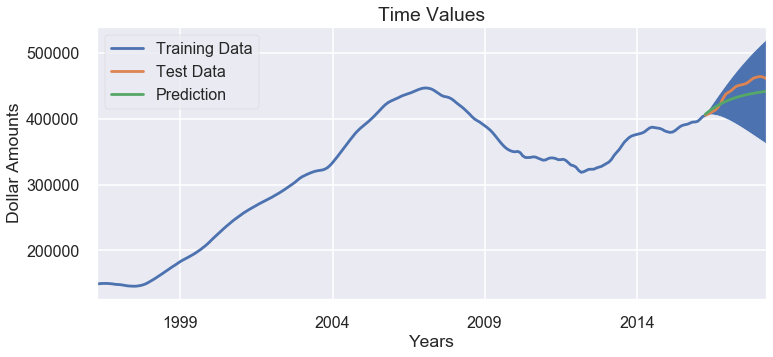

2016-04-01    407041.065856
2016-05-01    410212.000597
2016-06-01    413134.010099
2016-07-01    415826.635533
2016-08-01    418307.884044
2016-09-01    420594.349179
2016-10-01    422701.321852
2016-11-01    424642.892612
2016-12-01    426432.045866
2017-01-01    428080.746718
2017-02-01    429600.020986
2017-03-01    431000.028937
2017-04-01    432290.133234
2017-05-01    433478.961552
2017-06-01    434574.464275
2017-07-01    435583.967664
2017-08-01    436514.222852
2017-09-01    437371.450995
2017-10-01    438161.384875
2017-11-01    438889.307235
2017-12-01    439560.086115
2018-01-01    440178.207402
2018-02-01    440747.804830
2018-03-01    441272.687627
2018-04-01    441756.365989
Freq: MS, dtype: float64

In [61]:
graph_sarimax(ts_train, ts_test, output_test)

## Multi-Zip Initial Modeling

60613


,index,pdq,AIC
0,53,"(3, 1, 3)",4049.651862
1,59,"(3, 2, 4)",4054.539219
2,29,"(1, 2, 4)",4056.247261
3,74,"(4, 2, 4)",4056.484270
4,14,"(0, 2, 4)",4057.448026


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60613   No. Observations:                  265
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -2282.760
Date:                Fri, 17 Jan 2020   AIC                           4579.519
Time:                        19:05:58   BIC                           4604.444
Sample:                    04-01-1996   HQIC                          4589.539
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8009      0.186      4.297      0.000       0.436       1.166
ar.L2          0.3271      0.046      7.163      0.000       0.238       0.417
ar.L3         -0.1941      0.150     -1.295      0.195      -0.488       0.100
ma.L1          0.9622      0.247      3.891      0.000       0.478       1.447
ma.L2         -0.4337      0.292     -1.486      0.137      -1.006       0.138
ma.L3         -0.2057      0.096     -2.151      0.031      -0.393      -0.018
sigma2      2.121e+06   2.95e+05      7.194      0.000    1.54e+06     2.7e+06
===================================================================================
Ljung-Box (Q):                       92.48   Jarque-Bera (JB):               143.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              18.82   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

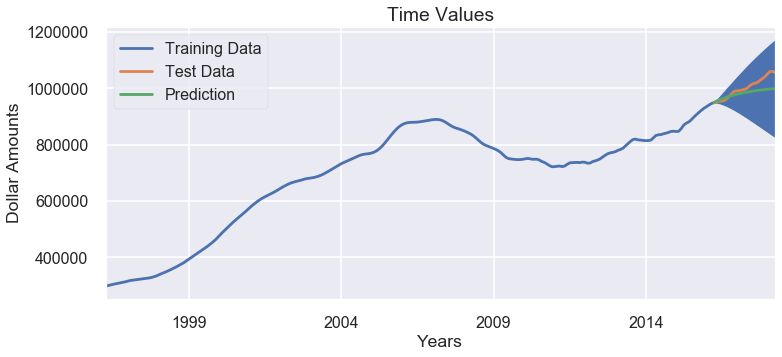

60618


,index,pdq,AIC
0,14,"(0, 2, 4)",3655.954340
1,29,"(1, 2, 4)",3656.001107
2,44,"(2, 2, 4)",3657.108460
3,59,"(3, 2, 4)",3657.399655
4,74,"(4, 2, 4)",3668.420291


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60618   No. Observations:                  265
Model:               SARIMAX(0, 2, 4)   Log Likelihood               -2029.672
Date:                Fri, 17 Jan 2020   AIC                           4069.345
Time:                        19:06:10   BIC                           4087.109
Sample:                    04-01-1996   HQIC                          4076.488
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9294      0.049     19.103      0.000       0.834       1.025
ma.L2         -0.0993      0.070     -1.421      0.155      -0.236       0.038
ma.L3         -0.4762      0.066     -7.207      0.000      -0.606      -0.347
ma.L4         -0.0856      0.045     -1.921      0.055      -0.173       0.002
sigma2      4.297e+05   2.85e+04     15.091      0.000    3.74e+05    4.86e+05
===================================================================================
Ljung-Box (Q):                       48.11   Jarque-Bera (JB):                82.55
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):              10.17   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

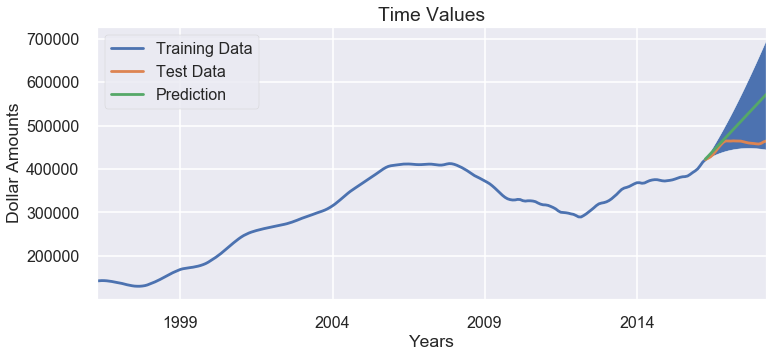

60625


,index,pdq,AIC
0,29,"(1, 2, 4)",3700.744987
1,59,"(3, 2, 4)",3701.358329
2,44,"(2, 2, 4)",3702.188396
3,74,"(4, 2, 4)",3704.867746
4,14,"(0, 2, 4)",3709.199165


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60625   No. Observations:                  265
Model:               SARIMAX(1, 2, 4)   Log Likelihood               -2046.430
Date:                Fri, 17 Jan 2020   AIC                           4104.860
Time:                        19:06:24   BIC                           4126.178
Sample:                    04-01-1996   HQIC                          4113.432
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3788      0.128     -2.957      0.003      -0.630      -0.128
ma.L1          1.0747      0.133      8.106      0.000       0.815       1.335
ma.L2         -0.0843      0.117     -0.722      0.470      -0.313       0.144
ma.L3         -0.5422      0.071     -7.612      0.000      -0.682      -0.403
ma.L4         -0.0291      0.083     -0.349      0.727      -0.192       0.134
sigma2      4.487e+05      3e+04     14.944      0.000     3.9e+05    5.08e+05
===================================================================================
Ljung-Box (Q):                       41.83   Jarque-Bera (JB):                76.53
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):              12.39   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

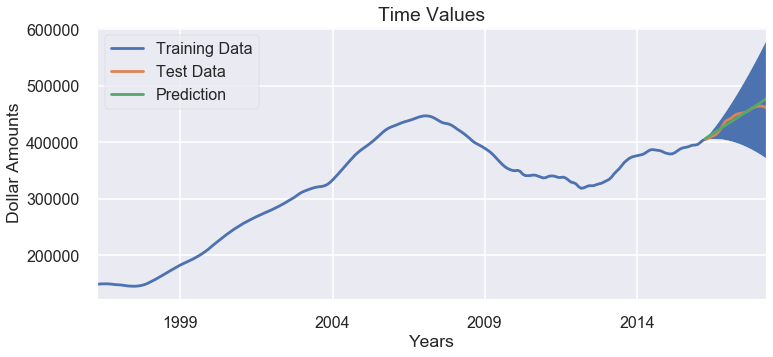

60630


,index,pdq,AIC
0,29,"(1, 2, 4)",3520.564083
1,44,"(2, 2, 4)",3520.677474
2,59,"(3, 2, 4)",3524.483030
3,14,"(0, 2, 4)",3524.507445
4,74,"(4, 2, 4)",3525.307087


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60630   No. Observations:                  265
Model:               SARIMAX(1, 2, 4)   Log Likelihood               -1942.950
Date:                Fri, 17 Jan 2020   AIC                           3897.901
Time:                        19:06:36   BIC                           3919.218
Sample:                    04-01-1996   HQIC                          3906.473
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4188      0.109     -3.828      0.000      -0.633      -0.204
ma.L1          1.0906      0.113      9.654      0.000       0.869       1.312
ma.L2          0.2859      0.103      2.771      0.006       0.084       0.488
ma.L3         -0.0843      0.070     -1.210      0.226      -0.221       0.052
ma.L4          0.1636      0.059      2.788      0.005       0.049       0.279
sigma2      2.027e+05   1.22e+04     16.638      0.000    1.79e+05    2.27e+05
===================================================================================
Ljung-Box (Q):                       56.76   Jarque-Bera (JB):                91.32
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               6.91   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

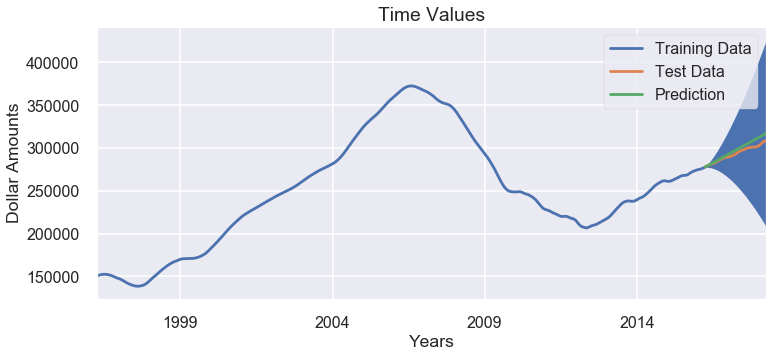

60640


,index,pdq,AIC
0,74,"(4, 2, 4)",4087.227485
1,59,"(3, 2, 4)",4093.068260
2,44,"(2, 2, 4)",4096.524482
3,54,"(3, 1, 4)",4098.941994
4,69,"(4, 1, 4)",4099.663170


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60640   No. Observations:                  265
Model:               SARIMAX(4, 2, 4)   Log Likelihood               -2289.918
Date:                Fri, 17 Jan 2020   AIC                           4597.836
Time:                        19:06:52   BIC                           4629.813
Sample:                    04-01-1996   HQIC                          4610.694
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9475      0.196      4.828      0.000       0.563       1.332
ar.L2         -0.9691      0.151     -6.415      0.000      -1.265      -0.673
ar.L3          0.5803      0.110      5.296      0.000       0.366       0.795
ar.L4         -0.3693      0.070     -5.304      0.000      -0.506      -0.233
ma.L1         -0.2988      0.202     -1.482      0.138      -0.694       0.096
ma.L2         -0.0118      0.071     -0.166      0.869      -0.151       0.128
ma.L3         -0.0984      0.104     -0.949      0.343      -0.302       0.105
ma.L4          0.0308      0.079      0.391      0.696      -0.124       0.185
sigma2       2.98e+06    1.8e+05     16.523      0.000    2.63e+06    3.33e+06
===================================================================================
Ljung-Box (Q):                      101.01   Jarque-Bera (JB):               171.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              45.56   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

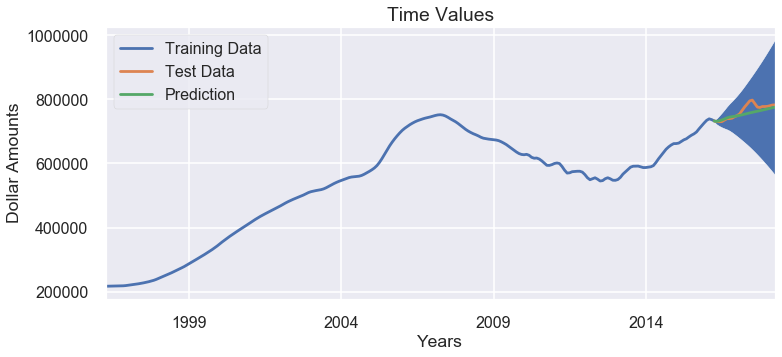

60645


,index,pdq,AIC
0,44,"(2, 2, 4)",3695.072860
1,29,"(1, 2, 4)",3695.073226
2,14,"(0, 2, 4)",3701.847257
3,74,"(4, 2, 4)",3706.018198
4,39,"(2, 1, 4)",3706.492129


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60645   No. Observations:                  265
Model:               SARIMAX(2, 2, 4)   Log Likelihood               -2026.235
Date:                Fri, 17 Jan 2020   AIC                           4066.470
Time:                        19:07:05   BIC                           4091.341
Sample:                    04-01-1996   HQIC                          4076.470
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3098      0.094     -3.307      0.001      -0.493      -0.126
ar.L2         -0.0701      0.080     -0.872      0.383      -0.228       0.087
ma.L1          1.0735      0.097     11.042      0.000       0.883       1.264
ma.L2         -0.0288      0.139     -0.207      0.836      -0.301       0.244
ma.L3         -0.6058      0.080     -7.549      0.000      -0.763      -0.448
ma.L4         -0.0915      0.047     -1.960      0.050      -0.183   -2.16e-05
sigma2       3.84e+05   2.09e+04     18.404      0.000    3.43e+05    4.25e+05
===================================================================================
Ljung-Box (Q):                       83.47   Jarque-Bera (JB):               127.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.41   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

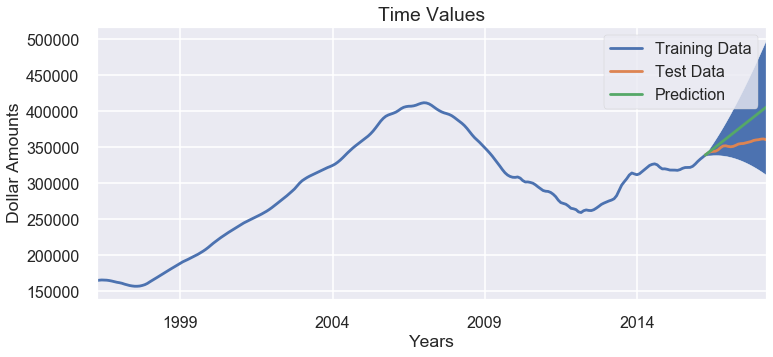

60657


,index,pdq,AIC
0,59,"(3, 2, 4)",4019.978939
1,44,"(2, 2, 4)",4021.318158
2,74,"(4, 2, 4)",4051.325082
3,14,"(0, 2, 4)",4055.403732
4,70,"(4, 2, 0)",4055.492465


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60657   No. Observations:                  265
Model:               SARIMAX(3, 2, 4)   Log Likelihood               -2224.086
Date:                Fri, 17 Jan 2020   AIC                           4464.171
Time:                        19:07:21   BIC                           4492.595
Sample:                    04-01-1996   HQIC                          4475.600
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5361      0.124     -4.330      0.000      -0.779      -0.293
ar.L2         -0.1385      0.133     -1.043      0.297      -0.399       0.122
ar.L3          0.1221      0.080      1.529      0.126      -0.034       0.278
ma.L1          1.3657      0.118     11.545      0.000       1.134       1.598
ma.L2          0.2889      0.212      1.366      0.172      -0.126       0.703
ma.L3         -0.6391      0.157     -4.082      0.000      -0.946      -0.332
ma.L4         -0.2363      0.043     -5.527      0.000      -0.320      -0.153
sigma2      2.136e+06   1.57e+05     13.623      0.000    1.83e+06    2.44e+06
===================================================================================
Ljung-Box (Q):                       74.16   Jarque-Bera (JB):               206.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              24.93   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

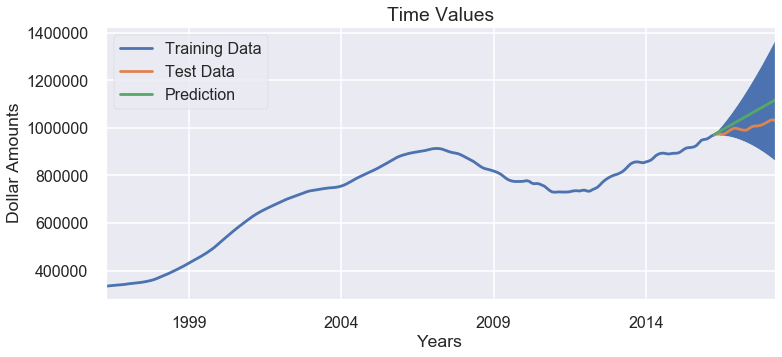

60659


,index,pdq,AIC
0,29,"(1, 2, 4)",3651.765779
1,59,"(3, 2, 4)",3651.986207
2,14,"(0, 2, 4)",3657.858347
3,58,"(3, 2, 3)",3666.857275
4,73,"(4, 2, 3)",3667.891400


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60659   No. Observations:                  265
Model:               SARIMAX(1, 2, 4)   Log Likelihood               -2012.873
Date:                Fri, 17 Jan 2020   AIC                           4037.746
Time:                        19:07:36   BIC                           4059.064
Sample:                    04-01-1996   HQIC                          4046.318
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2152      0.159     -1.355      0.175      -0.526       0.096
ma.L1          1.0306      0.163      6.339      0.000       0.712       1.349
ma.L2         -0.1037      0.143     -0.725      0.469      -0.384       0.177
ma.L3         -0.5921      0.077     -7.731      0.000      -0.742      -0.442
ma.L4         -0.1056      0.087     -1.213      0.225      -0.276       0.065
sigma2      3.814e+05   2.43e+04     15.696      0.000    3.34e+05    4.29e+05
===================================================================================
Ljung-Box (Q):                       49.16   Jarque-Bera (JB):               214.06
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):              13.89   Skew:                            -0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

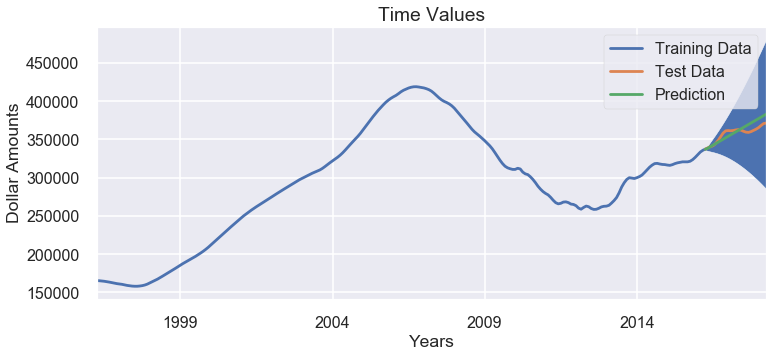

60660


,index,pdq,AIC
0,69,"(4, 1, 4)",3982.518717
1,74,"(4, 2, 4)",3984.442186
2,54,"(3, 1, 4)",3988.294495
3,59,"(3, 2, 4)",3989.125594
4,44,"(2, 2, 4)",3989.456205


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60660   No. Observations:                  265
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -2194.333
Date:                Fri, 17 Jan 2020   AIC                           4406.665
Time:                        19:07:51   BIC                           4438.677
Sample:                    04-01-1996   HQIC                          4419.536
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3383      0.320     -1.058      0.290      -0.965       0.289
ar.L2          0.3527      0.175      2.015      0.044       0.010       0.696
ar.L3          0.2463      0.170      1.448      0.148      -0.087       0.580
ar.L4          0.1519      0.081      1.871      0.061      -0.007       0.311
ma.L1          2.1001      0.327      6.423      0.000       1.459       2.741
ma.L2          1.8585      0.555      3.351      0.001       0.771       2.945
ma.L3          0.7241      0.397      1.823      0.068      -0.054       1.503
ma.L4          0.1845      0.162      1.138      0.255      -0.133       0.502
sigma2      1.573e+06   1.32e+05     11.918      0.000    1.31e+06    1.83e+06
===================================================================================
Ljung-Box (Q):                       91.43   Jarque-Bera (JB):                60.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              12.67   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.41e+14. Standard errors may be unstable.
"""

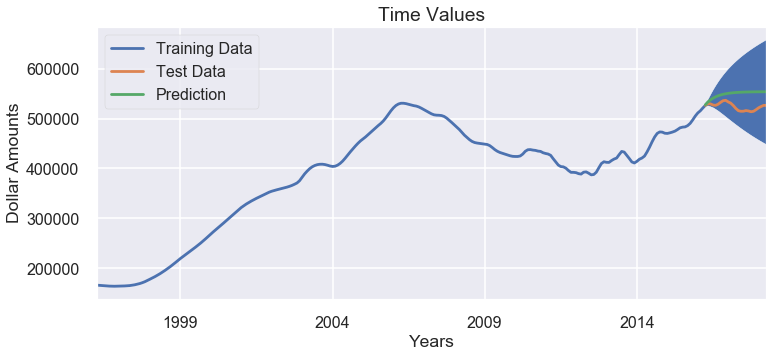

In [62]:
from sklearn.metrics import mean_squared_error,r2_score

result = [['Zip Code', 'Metric', 'Value']]  

for z in far_northside:  # far_northside is a list of far north zip codes
    
    print(z)
    ts=get_ts_from_chicago(chicago, z)
    
    #Get params
    best_params, ts_train, ts_test = get_best_params_2(ts, p_range=5, d_range=3, q_range=5, start_date='2016-04-01') 
    #Create model and fit model
    output = model_multi_zip(ts, best_params)
    #Graph 
    ts_pred = graph_sarimax(ts_train, ts_test, output=output)
    
   
    result.append([z,'RMSE', np.sqrt(mean_squared_error(ts_test,ts_pred))]) 
    result.append([z,'R2',r2_score(ts_test,ts_pred)])
    
z_model_df = pd.DataFrame(result)
    
    


In [63]:
z_model_df

,0,1,2
0,Zip Code,Metric,Value
1,60613,RMSE,29935.6
2,60613,R2,0.280472
3,60618,RMSE,56214.8
4,60618,R2,-16.6067
5,60625,RMSE,5748.82
6,60625,R2,0.917859
7,60630,RMSE,5244.86
8,60630,R2,0.651
9,60640,RMSE,15445.7


# Step 6: Interpreting Results

In [64]:
def expected_roi(investment, final_value):
    """This function takes in a series of forecasts to predict the return
    on investment spanning the entire forecast."""
    roi = np.round(((final_value - investment) / investment)*100,3)
    return roi

In [65]:

def forecast_graph_sarimax(ts, output=output):
       
    # Getting predictions starting from 2016 and calculate confidence intervals.
    predictions = output.get_prediction(start= pd.to_datetime('2018-04-01'), end= pd.to_datetime('2028-04-01'), dynamic=True)
    ts_pred = predictions.predicted_mean
    ts_conf = predictions.conf_int()  #makes confidence intereval graph
    
    investment = ts[start]
    final_value = ts_pred[end]
    
    e_roi = expected_roi(investment, final_value)
    
    ts.plot(label= 'Raw Data')
    ts_pred.plot(label= 'Prediction')
    plt.fill_between(ts_conf.index, ts_conf.iloc[:,0], ts_conf.iloc[:,1])  #confidence interval
    plt.legend()
    plt.ylabel('Dollar Amounts')
    plt.xlabel('Years')
    plt.title('Time Values (ROI equals' + str(e_roi)+')')
    plt.show()
    
    return ts_pred


60613


,index,pdq,AIC
0,8,"(2, 0, 2)",4176.249196
1,6,"(2, 0, 0)",4215.040700
2,7,"(2, 0, 1)",4217.687914
3,5,"(1, 0, 2)",4414.794288
4,4,"(1, 0, 1)",4506.367124


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60613   No. Observations:                  265
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -2316.958
Date:                Fri, 17 Jan 2020   AIC                           4643.916
Time:                        19:07:53   BIC                           4661.758
Sample:                    04-01-1996   HQIC                          4651.087
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8779      0.028     67.554      0.000       1.823       1.932
ar.L2         -0.8776      0.028    -31.452      0.000      -0.932      -0.823
ma.L1          0.3621      0.030     12.027      0.000       0.303       0.421
ma.L2          0.0720      0.014      5.113      0.000       0.044       0.100
sigma2      2.176e+06   1.17e-08   1.86e+14      0.000    2.18e+06    2.18e+06
===================================================================================
Ljung-Box (Q):                      116.81   Jarque-Bera (JB):               151.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.97   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.09e+31. Standard errors may be unstable.
"""

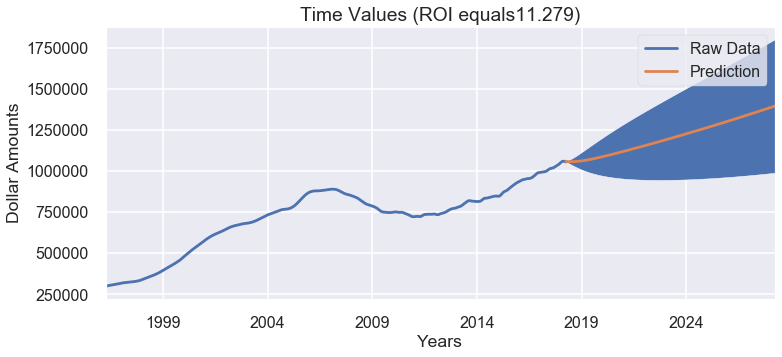

60618


,index,pdq,AIC
0,8,"(2, 0, 2)",3809.912232
1,6,"(2, 0, 0)",3877.188278
2,7,"(2, 0, 1)",3882.059735
3,5,"(1, 0, 2)",4161.906219
4,4,"(1, 0, 1)",4252.266299


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60618   No. Observations:                  265
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -2112.285
Date:                Fri, 17 Jan 2020   AIC                           4234.571
Time:                        19:07:55   BIC                           4252.413
Sample:                    04-01-1996   HQIC                          4241.742
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7195      0.029     59.771      0.000       1.663       1.776
ar.L2         -0.7187      0.029    -24.883      0.000      -0.775      -0.662
ma.L1          1.5847      0.060     26.302      0.000       1.467       1.703
ma.L2          0.4415      0.050      8.848      0.000       0.344       0.539
sigma2      4.353e+05   9.49e-08   4.59e+12      0.000    4.35e+05    4.35e+05
===================================================================================
Ljung-Box (Q):                      123.52   Jarque-Bera (JB):               661.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.46   Skew:                            -1.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.92e+28. Standard errors may be unstable.
"""

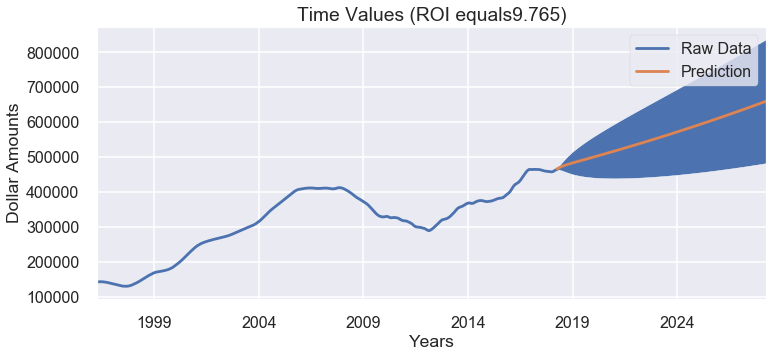

60625


,index,pdq,AIC
0,8,"(2, 0, 2)",3890.420345
1,6,"(2, 0, 0)",3894.550954
2,7,"(2, 0, 1)",3896.312150
3,5,"(1, 0, 2)",4148.004563
4,4,"(1, 0, 1)",4228.129228


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60625   No. Observations:                  265
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -2100.960
Date:                Fri, 17 Jan 2020   AIC                           4211.920
Time:                        19:07:57   BIC                           4229.762
Sample:                    04-01-1996   HQIC                          4219.091
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8315      0.028     66.377      0.000       1.777       1.886
ar.L2         -0.8311      0.028    -30.066      0.000      -0.885      -0.777
ma.L1          0.8390      0.043     19.566      0.000       0.755       0.923
ma.L2          0.1841      0.024      7.773      0.000       0.138       0.230
sigma2      5.136e+05   1.77e-08   2.91e+13      0.000    5.14e+05    5.14e+05
===================================================================================
Ljung-Box (Q):                       78.25   Jarque-Bera (JB):               109.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.62   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.68e+29. Standard errors may be unstable.
"""

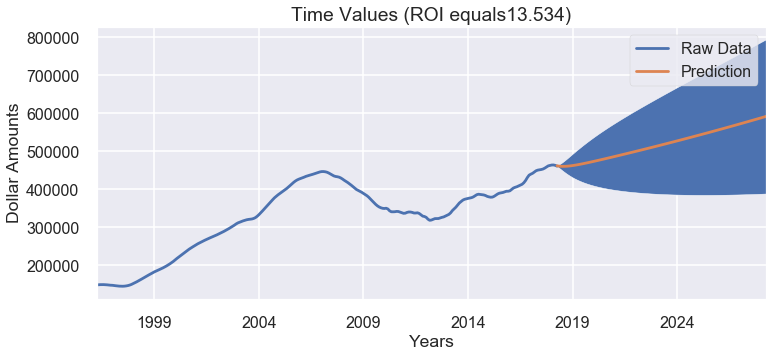

60630


,index,pdq,AIC
0,8,"(2, 0, 2)",3596.406659
1,6,"(2, 0, 0)",3683.747689
2,7,"(2, 0, 1)",3684.816215
3,5,"(1, 0, 2)",4132.903421
4,4,"(1, 0, 1)",4206.947322


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60630   No. Observations:                  265
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -1981.999
Date:                Fri, 17 Jan 2020   AIC                           3973.998
Time:                        19:07:58   BIC                           3991.840
Sample:                    04-01-1996   HQIC                          3981.169
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9531      0.023     83.994      0.000       1.908       1.999
ar.L2         -0.9531      0.023    -41.026      0.000      -0.999      -0.908
ma.L1          0.6163      0.055     11.211      0.000       0.509       0.724
ma.L2          0.0634      0.024      2.659      0.008       0.017       0.110
sigma2      2.181e+05   4.96e-08    4.4e+12      0.000    2.18e+05    2.18e+05
===================================================================================
Ljung-Box (Q):                       91.61   Jarque-Bera (JB):                52.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.02   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.76e+28. Standard errors may be unstable.
"""

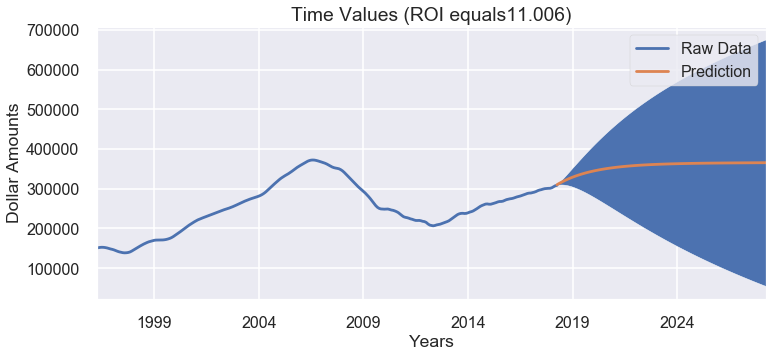

60640


,index,pdq,AIC
0,8,"(2, 0, 2)",4248.369114
1,6,"(2, 0, 0)",4316.674803
2,7,"(2, 0, 1)",4322.660455
3,5,"(1, 0, 2)",4394.725203
4,4,"(1, 0, 1)",4510.495112


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60640   No. Observations:                  265
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -2372.013
Date:                Fri, 17 Jan 2020   AIC                           4754.027
Time:                        19:08:00   BIC                           4771.868
Sample:                    04-01-1996   HQIC                          4761.198
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7647      0.030     59.155      0.000       1.706       1.823
ar.L2         -0.7641      0.030    -25.591      0.000      -0.823      -0.706
ma.L1          0.4825      0.024     20.370      0.000       0.436       0.529
ma.L2          0.1284      0.016      8.161      0.000       0.098       0.159
sigma2      3.216e+06   8.59e-09   3.74e+14      0.000    3.22e+06    3.22e+06
===================================================================================
Ljung-Box (Q):                      166.66   Jarque-Bera (JB):               254.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              11.62   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.4e+29. Standard errors may be unstable.
"""

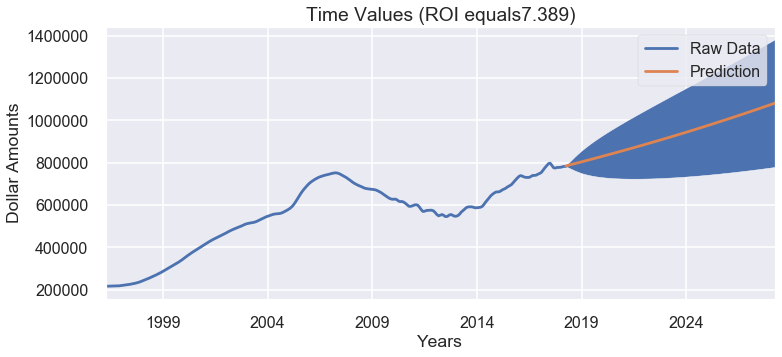

60645


,index,pdq,AIC
0,8,"(2, 0, 2)",3808.224313
1,6,"(2, 0, 0)",3910.197595
2,7,"(2, 0, 1)",3912.221546
3,5,"(1, 0, 2)",4128.916668
4,4,"(1, 0, 1)",4211.837470


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60645   No. Observations:                  265
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -2126.123
Date:                Fri, 17 Jan 2020   AIC                           4262.246
Time:                        19:08:02   BIC                           4280.088
Sample:                    04-01-1996   HQIC                          4269.417
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5819      0.028     57.028      0.000       1.528       1.636
ar.L2         -0.5812      0.028    -20.901      0.000      -0.636      -0.527
ma.L1          1.6340      0.066     24.713      0.000       1.504       1.764
ma.L2          0.4731      0.057      8.368      0.000       0.362       0.584
sigma2      4.351e+05   5.87e-08   7.42e+12      0.000    4.35e+05    4.35e+05
===================================================================================
Ljung-Box (Q):                      179.18   Jarque-Bera (JB):               386.58
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                            -1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.49e+28. Standard errors may be unstable.
"""

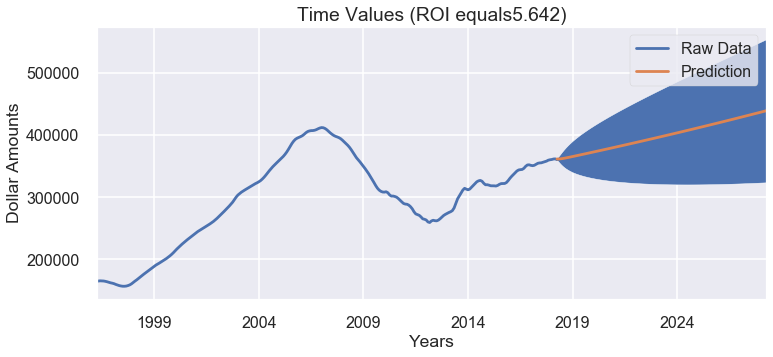

60657


,index,pdq,AIC
0,8,"(2, 0, 2)",4209.034008
1,6,"(2, 0, 0)",4245.314357
2,7,"(2, 0, 1)",4248.915414
3,5,"(1, 0, 2)",4412.038931
4,4,"(1, 0, 1)",4504.531053


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60657   No. Observations:                  265
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -2329.426
Date:                Fri, 17 Jan 2020   AIC                           4668.852
Time:                        19:08:03   BIC                           4686.694
Sample:                    04-01-1996   HQIC                          4676.023
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8459      0.025     75.235      0.000       1.798       1.894
ar.L2         -0.8456      0.025    -34.369      0.000      -0.894      -0.797
ma.L1          0.3933      0.021     18.559      0.000       0.352       0.435
ma.L2          0.0848      0.010      8.303      0.000       0.065       0.105
sigma2      2.139e+06    6.7e-09   3.19e+14      0.000    2.14e+06    2.14e+06
===================================================================================
Ljung-Box (Q):                      160.04   Jarque-Bera (JB):                67.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.90   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.49e+29. Standard errors may be unstable.
"""

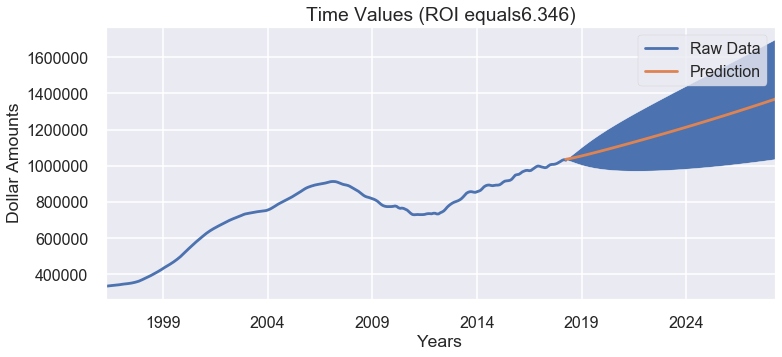

60659


,index,pdq,AIC
0,8,"(2, 0, 2)",3832.073692
1,6,"(2, 0, 0)",3863.658228
2,7,"(2, 0, 1)",3866.299234
3,5,"(1, 0, 2)",4141.082155
4,4,"(1, 0, 1)",4224.051967


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60659   No. Observations:                  265
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -2105.604
Date:                Fri, 17 Jan 2020   AIC                           4221.208
Time:                        19:08:05   BIC                           4239.050
Sample:                    04-01-1996   HQIC                          4228.379
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6865      0.032     52.042      0.000       1.623       1.750
ar.L2         -0.6860      0.033    -21.077      0.000      -0.750      -0.622
ma.L1          1.5815      0.056     28.394      0.000       1.472       1.691
ma.L2          0.4161      0.047      8.900      0.000       0.324       0.508
sigma2      3.962e+05   5.96e-08   6.64e+12      0.000    3.96e+05    3.96e+05
===================================================================================
Ljung-Box (Q):                      132.54   Jarque-Bera (JB):               914.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.36   Skew:                            -1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.61e+28. Standard errors may be unstable.
"""

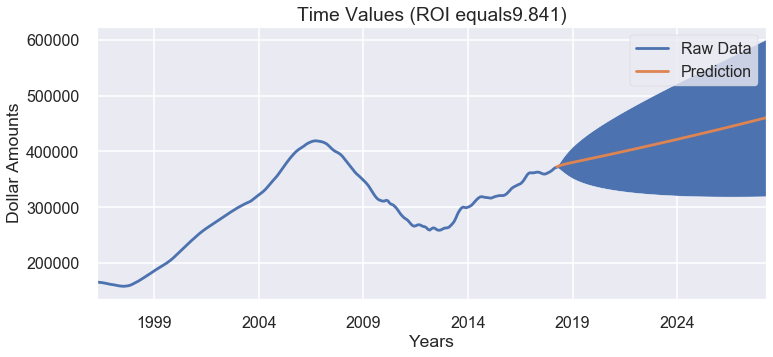

60660


,index,pdq,AIC
0,8,"(2, 0, 2)",4107.962440
1,6,"(2, 0, 0)",4190.117437
2,7,"(2, 0, 1)",4196.742417
3,5,"(1, 0, 2)",4247.394436
4,4,"(1, 0, 1)",4384.402922


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  60660   No. Observations:                  265
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -2262.678
Date:                Fri, 17 Jan 2020   AIC                           4535.356
Time:                        19:08:07   BIC                           4553.197
Sample:                    04-01-1996   HQIC                          4542.527
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7874      0.036     49.467      0.000       1.717       1.858
ar.L2         -0.7870      0.036    -21.718      0.000      -0.858      -0.716
ma.L1          0.5546      0.029     18.821      0.000       0.497       0.612
ma.L2          0.1515      0.018      8.517      0.000       0.117       0.186
sigma2      1.764e+06   1.26e-08    1.4e+14      0.000    1.76e+06    1.76e+06
===================================================================================
Ljung-Box (Q):                      133.63   Jarque-Bera (JB):               109.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.48   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.91e+29. Standard errors may be unstable.
"""

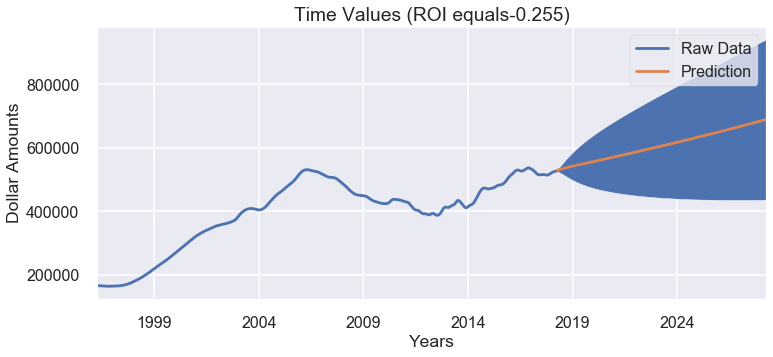

In [66]:
from sklearn.metrics import mean_squared_error,r2_score

result = [['Zip Code', 'Metric', 'Value']]  

for z in far_northside:  # far_northside is a list of far north zip codes
    
    print(z)
    ts=get_ts_from_chicago(chicago, z)
    
    #Get params
    best_params, ts_train, ts_test = get_best_params_2(ts, p_range=3, d_range=1, q_range=3, 
                                                       start_date='2016-04-01') 
    #Create model and fit model
    output = model_multi_zip(ts, best_params)
    #Graph 
    ts_pred = forecast_graph_sarimax(ts, output=output)
   
    
z_model_df = pd.DataFrame(result)

## Top 5 Zip Codes (Ranked Only by ROI)

In [71]:
zip_25 = get_ts_from_chicago(chicago, 60625)

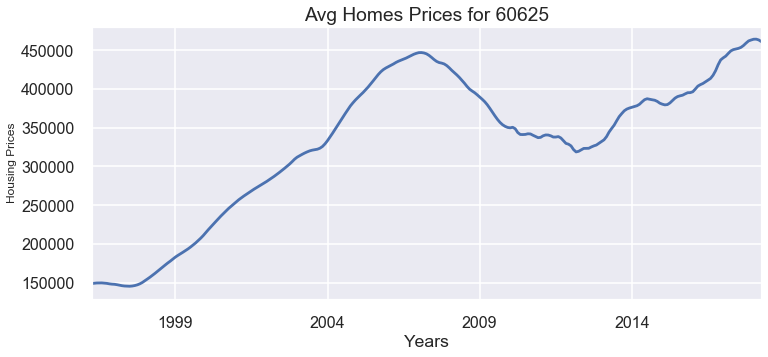

In [73]:
zip_25.plot()
plt.title('Avg Homes Prices for 60625')
plt.ylabel('Housing Prices', fontsize= 12)
plt.xlabel('Years')
plt.show()

In [74]:
zip_13 = get_ts_from_chicago(chicago, 60613)

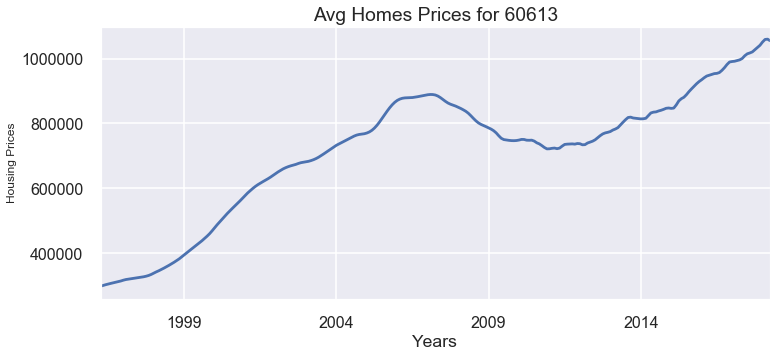

In [75]:
zip_13.plot()
plt.title('Avg Homes Prices for 60613')
plt.ylabel('Housing Prices', fontsize= 12)
plt.xlabel('Years')
plt.show()

In [76]:
zip_30 = get_ts_from_chicago(chicago, 60630)

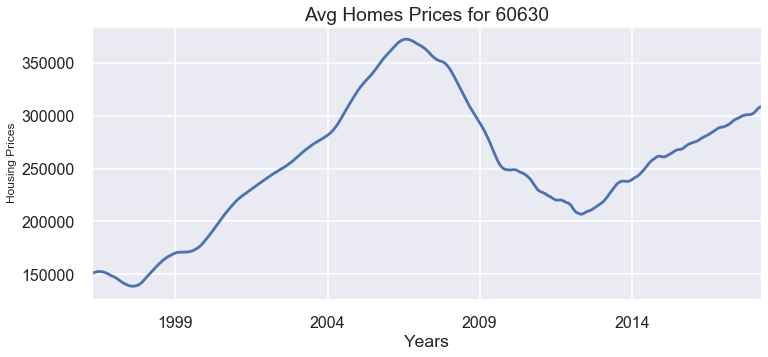

In [77]:
zip_30.plot()
plt.title('Avg Homes Prices for 60630')
plt.ylabel('Housing Prices', fontsize= 12)
plt.xlabel('Years')
plt.show()

In [79]:
zip_59= get_ts_from_chicago(chicago, 60659)

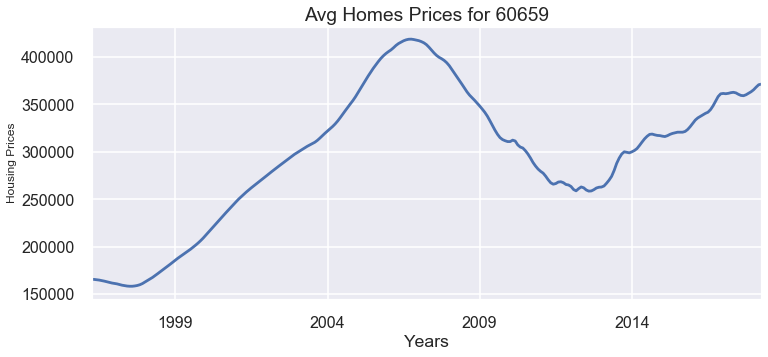

In [80]:
zip_59.plot()
plt.title('Avg Homes Prices for 60659')
plt.ylabel('Housing Prices', fontsize= 12)
plt.xlabel('Years')
plt.show()

In [81]:
zip_18 = get_ts_from_chicago(chicago, 60618)

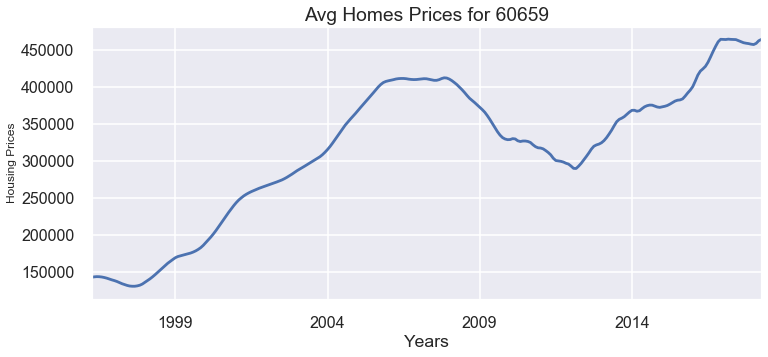

In [82]:
zip_18.plot()
plt.title('Avg Homes Prices for 60659')
plt.ylabel('Housing Prices', fontsize= 12)
plt.xlabel('Years')
plt.show()